# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Описание данных

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### Библиотеки

In [1]:
# загружаем используемые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler 

import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
# немного переменных и настроек
RANDOM_STATE = 42

### Загружаем данные

In [3]:
pth0 = 'datasets/geo_data_0.csv'
pth1 = 'datasets/geo_data_1.csv'
pth2 = 'datasets/geo_data_2.csv'

if os.path.exists(pth0) and os.path.exists(pth1) and os.path.exists(pth2):
    data0 = pd.read_csv(pth0)
    data1 = pd.read_csv(pth1)
    data2 = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
# использую метод пристального взгляда посмотрим на данные
display(data0.head(), data1.head(), data2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
#На первый взгляд, данные скачались и "зашли" в df хорошо. Плохо, что уже видны пропуски. Изучим их.
data0.isna().sum(), data1.isna().sum(), data2.isna().sum()

(id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64)

In [6]:
# Пропуской нет. Посмотрим на данные "общими мазками"
display(data0.describe(), data1.describe(), data2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
# Проверим типы данных:
data0.info(), data1.info(), data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

(None, None, None)

In [8]:
# Посмотрим распределение по каждому региону:
def data_distribution(data):
    data.hist(figsize=(10,7),
              bins=100,
              color = 'blue')
    plt.show()

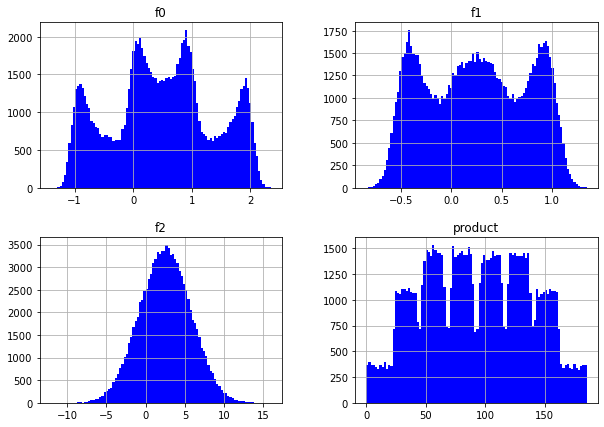

In [9]:
data_distribution(data0)


Нормальное распределение с разивкой на 1000 корзин отмечается только у произнака f2. Остальные не относятся в нормальному распределению.

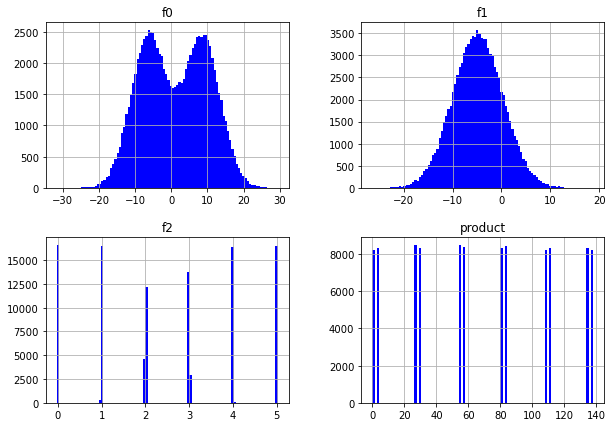

In [10]:
data_distribution(data1)


Во втором регионе имеет нормальное распределение признак F1. F0 - распределение с изолированным пиком. Целевая функция (product) - равномерное.

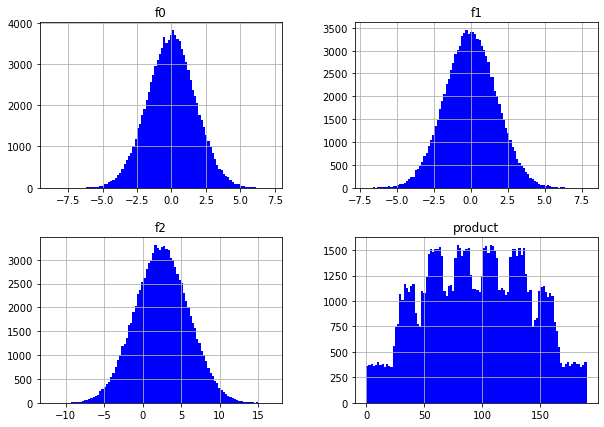

In [11]:
data_distribution(data2)

### Проверка корреляции признаков

In [12]:
corr = data0.corr()
corr.style.background_gradient(cmap='coolwarm')


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
corr = data1.corr()
corr.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [14]:
corr = data2.corr()
corr.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


На данных третьего региона отмечается по признакам f0, f1, f2 нормальное распределение. Все три региона очень разные.

In [15]:
# Удалим столбцы ID, которые не будум использоваться при обучении.
data0 = data0.drop('id', axis=1)
data1 = data1.drop('id', axis=1)
data2 = data2.drop('id', axis=1)
print(data0.shape, data1.shape, data2.shape)

(100000, 4) (100000, 4) (100000, 4)


Данные загружены и подготовлены. Ура!

## Обучение и проверка модели

Рассмотрим первую модель

In [16]:
y = data0['product']
X = data0.drop('product', axis=1)

In [17]:
def split_data(X, y): #--> X_train, X_val, X_test, y_train, у_val, y_test
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = 0.25,
                                                      train_size = 0.75,
                                                        random_state=RANDOM_STATE)
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_data(X, y)

In [18]:
def LM_model_and_StandardScaler(data, name_region):
    
    # Разделение на фичи и целевую функцию
    y = data['product']
    X = data.drop('product', axis=1)
    
    # Разбиение на выборки датасета
    X_train, X_val, y_train, y_val = split_data(X, y)  
    
    # Стандартизация диапазон
    scaler = StandardScaler()
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Обучение модели предскажем значение функции на валидационных данных
    LM = LinearRegression()
    LM.fit(X_train, y_train)
    y_pred = LM.predict(X_val)
    
    # Найдем среднее по предсазанию на валидачинной выборке
    mean_y_val = y_val.mean()
    
    # Найдем среднее по предсазанию на предсказанной выборке
    mean_y_pred = y_pred.mean()
    
    # посчитаем RMSE
    rmse = mean_squared_error(y_val, y_pred)**0.5
    
    return name_region, mean_y_val, mean_y_pred, rmse, y_pred, y_val

In [19]:
# создадим df для исследований
model_rep = pd.DataFrame({"Регион": [],
                          "Фактический объем": [],
                          "Предсказанный объем": [],
                          "RMSE": []})
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE


In [20]:
# Посмотрим данные по первому региону.
name_region, mean_y_val, mean_y_pred, rmse, y_pred0, y_val0 = LM_model_and_StandardScaler(data0, 'Первый')    

model_rep = model_rep.append({"Регион": name_region,
                          "Фактический объем": mean_y_val,
                          "Предсказанный объем": mean_y_pred,
                          "RMSE": rmse},
                         ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_1992\3590826368.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"Регион": name_region,


,Регион,Фактический объем,Предсказанный объем,RMSE
0,Первый,92.325956,92.3988,37.7566


In [21]:
# Посмотрим данные по второму региону.
name_region, sum_y_val, sum_y_pred, rmse, y_pred1, y_val1 = LM_model_and_StandardScaler(data1, 'Второй')    

model_rep = model_rep.append({"Регион": name_region,
                          "Фактический объем": sum_y_val,
                          "Предсказанный объем": sum_y_pred,
                          "RMSE": rmse},
                         ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_1992\142545914.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"Регион": name_region,


,Регион,Фактический объем,Предсказанный объем,RMSE
0,Первый,92.325956,92.398800,37.75660
1,Второй,68.725381,68.712878,0.89028


In [22]:
# Посмотрим данные по третьему региону.
name_region, sum_y_val, sum_y_pred, rmse, y_pred2, y_val2 = LM_model_and_StandardScaler(data2, 'Третий')    

model_rep = model_rep.append({"Регион": name_region,
                          "Фактический объем": sum_y_val,
                          "Предсказанный объем": sum_y_pred,
                          "RMSE": rmse},
                         ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_1992\2055860774.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"Регион": name_region,


,Регион,Фактический объем,Предсказанный объем,RMSE
0,Первый,92.325956,92.398800,37.756600
1,Второй,68.725381,68.712878,0.890280
2,Третий,95.150999,94.771024,40.145872


Вывод: Отмечается, что во втором регионе наименьшая ошибка (RMSE). Также важным фактором является наименьший объем (относительно первого и второ регионов).

## Подготовка к расчёту прибыли

In [23]:
# цена единицы продукта (тысячи баррелей)
BARREL_PRICE = 450_000 

# бюджет на разработку скважин в каждом регионе
BUDGET = 100_00_000_000 

# количество скважин для разработки в регионе
POINT_QNT = 200 

# количество исследуемых скважин
POINT_SAMPLE_SIZE = 500 

In [24]:
# Минимальное количество тысяч баррелей из скважины для безубыточности
min_barrels = BUDGET / POINT_QNT / BARREL_PRICE
min_barrels

111.11111111111111

__Вывод:__
* Достаточное количество тысяч баррелей из скважины для безубыточности:  112
* Средний запас в каждом регионе ниже достаточного объёма для безубыточности. Для достижения этого условия следует рассматривать скважины с запасом более 112 тыс. баррелей.

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- 4.1. Выберите скважины с максимальными значениями предсказаний.
- 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [25]:
# Напишем функцию, которая будет находить скважены с максимальным количеством предсказаний
def calc_income(y_pred, y, count):
    #y_pred = pd.Series(y_pred)
    y_pred = pd.Series(y_pred, index=y.index)
    predictions_max = y_pred.sort_values(ascending=False)[:count].index
    y_val = y[predictions_max].sum()                           # y_val - Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    income_value = y_val * BARREL_PRICE - BUDGET               # income_value - Рассчитайте прибыль для полученного объёма сырья
    return y_val, income_value


In [26]:
# Превый регион
target_value, income_value = calc_income(y_pred0, y_val0, POINT_QNT)
model_rep.loc[model_rep['Регион']=='Первый', 'Цель'] = target_value
model_rep.loc[model_rep['Регион']=='Первый', 'Прибыль'] = income_value/10**9
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE,Цель,Прибыль
0,Первый,92.325956,92.398800,37.756600,29686.980254,3.359141
1,Второй,68.725381,68.712878,0.890280,NaN,NaN
2,Третий,95.150999,94.771024,40.145872,NaN,NaN


In [27]:
# Второй регион
target_value, income_value = calc_income(y_pred1, y_val1, POINT_QNT)
model_rep.loc[model_rep['Регион']=='Второй', 'Цель'] = target_value
model_rep.loc[model_rep['Регион']=='Второй', 'Прибыль'] = income_value/10**9
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE,Цель,Прибыль
0,Первый,92.325956,92.398800,37.756600,29686.980254,3.359141
1,Второй,68.725381,68.712878,0.890280,27589.081548,2.415087
2,Третий,95.150999,94.771024,40.145872,NaN,NaN


In [28]:
# Третий регион
target_value, income_value = calc_income(y_pred2, y_val2, POINT_QNT)
model_rep.loc[model_rep['Регион']=='Третий', 'Цель'] = target_value
model_rep.loc[model_rep['Регион']=='Третий', 'Прибыль'] = income_value/10**9
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE,Цель,Прибыль
0,Первый,92.325956,92.398800,37.756600,29686.980254,3.359141
1,Второй,68.725381,68.712878,0.890280,27589.081548,2.415087
2,Третий,95.150999,94.771024,40.145872,27996.826132,2.598572


Вывод: <br>
Все регионы указались прибыльными. Самый прибыльный регион оказывается "Первый". 

## Посчитайте риски и прибыль для каждого региона

Посчитайте риски и прибыль для каждого региона:
- 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [29]:
# Бутстрап по первому региону
y_val0 = y_val0.reset_index(drop=True)
values = []

rs = np.random.RandomState(153456)

for i in range(1000):
    target_subsample = y_val0.sample(n=POINT_SAMPLE_SIZE,
                                                     replace=True,
                                                     random_state=rs)
    predictions_subsample = y_pred0[target_subsample.index] 
    target_value, income_value = calc_income(predictions_subsample, target_subsample, POINT_QNT)
    values.append(income_value)
    
values = pd.Series(values)
confidence_interval = (round(values.quantile(0.025)/pow(10,6),2), round(values.quantile(0.975)/pow(10,6),2))
mean_profit = values.mean()
negative_profit_chance = (values < 0).mean()*100   

#print(mean_profit, list(confidence_interval), negative_profit_chance)

model_rep.loc[model_rep['Регион']=='Первый', 'Средняя прибыль'] = mean_profit/10**6
model_rep.loc[model_rep['Регион']=='Первый', 'Дов. интервал - 2.5%'] = confidence_interval[0]
model_rep.loc[model_rep['Регион']=='Первый', 'Дов. интервал + 2.5%'] = confidence_interval[1] 
model_rep.loc[model_rep['Регион']=='Первый', 'Вероятность убыточности'] = negative_profit_chance
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE,Цель,Прибыль,Средняя прибыль,Дов. интервал - 2.5%,Дов. интервал + 2.5%,Вероятность убыточности
0,Первый,92.325956,92.398800,37.756600,29686.980254,3.359141,619.237053,45.43,1275.89,2.0
1,Второй,68.725381,68.712878,0.890280,27589.081548,2.415087,NaN,NaN,NaN,NaN
2,Третий,95.150999,94.771024,40.145872,27996.826132,2.598572,NaN,NaN,NaN,NaN


In [30]:
# Бутстрап по второму региону
y_val1 = y_val1.reset_index(drop=True)
values = []
for i in range(1000):
    target_subsample = y_val1.sample(n=POINT_SAMPLE_SIZE,
                                                     replace=True,
                                                     random_state=rs)
    predictions_subsample = y_pred1[target_subsample.index] 
    target_value, income_value = calc_income(predictions_subsample, target_subsample, POINT_QNT)
    values.append(income_value)
    
values = pd.Series(values)
confidence_interval = (round(values.quantile(0.025)/pow(10,6),2), round(values.quantile(0.975)/pow(10,6),2))
mean_profit = values.mean()
negative_profit_chance = (values < 0).mean()*100   

#print(mean_profit, list(confidence_interval), negative_profit_chance)

model_rep.loc[model_rep['Регион']=='Второй', 'Средняя прибыль'] = mean_profit/10**6
model_rep.loc[model_rep['Регион']=='Второй', 'Дов. интервал - 2.5%'] = confidence_interval[0]
model_rep.loc[model_rep['Регион']=='Второй', 'Дов. интервал + 2.5%'] = confidence_interval[1] 
model_rep.loc[model_rep['Регион']=='Второй', 'Вероятность убыточности'] = negative_profit_chance
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE,Цель,Прибыль,Средняя прибыль,Дов. интервал - 2.5%,Дов. интервал + 2.5%,Вероятность убыточности
0,Первый,92.325956,92.398800,37.756600,29686.980254,3.359141,619.237053,45.43,1275.89,2.0
1,Второй,68.725381,68.712878,0.890280,27589.081548,2.415087,638.969217,146.25,1205.51,0.4
2,Третий,95.150999,94.771024,40.145872,27996.826132,2.598572,NaN,NaN,NaN,NaN


In [31]:
# Бутстрап по второму региону
y_val2 = y_val2.reset_index(drop=True)
values = []
for i in range(1000):
    target_subsample = y_val2.sample(n=POINT_SAMPLE_SIZE,
                                                     replace=True,
                                                     random_state=rs)
    predictions_subsample = y_pred2[target_subsample.index] 
    target_value, income_value = calc_income(predictions_subsample, target_subsample, POINT_QNT)
    values.append(income_value)
    
values = pd.Series(values)
confidence_interval = (round(values.quantile(0.025)/pow(10,6),2), round(values.quantile(0.975)/pow(10,6),2))
mean_profit = values.mean()
negative_profit_chance = (values < 0).mean()*100   

#print(mean_profit, list(confidence_interval), negative_profit_chance)

model_rep.loc[model_rep['Регион']=='Третий', 'Средняя прибыль'] = mean_profit/10**6
model_rep.loc[model_rep['Регион']=='Третий', 'Дов. интервал - 2.5%'] = confidence_interval[0]
model_rep.loc[model_rep['Регион']=='Третий', 'Дов. интервал + 2.5%'] = confidence_interval[1] 
model_rep.loc[model_rep['Регион']=='Третий', 'Вероятность убыточности'] = negative_profit_chance
model_rep

,Регион,Фактический объем,Предсказанный объем,RMSE,Цель,Прибыль,Средняя прибыль,Дов. интервал - 2.5%,Дов. интервал + 2.5%,Вероятность убыточности
0,Первый,92.325956,92.398800,37.756600,29686.980254,3.359141,619.237053,45.43,1275.89,2.0
1,Второй,68.725381,68.712878,0.890280,27589.081548,2.415087,638.969217,146.25,1205.51,0.4
2,Третий,95.150999,94.771024,40.145872,27996.826132,2.598572,585.032105,25.00,1223.48,2.1


__Выводы:__
Поосле использования Бутстрапа изменилось предложение по целесообразности выбора региона. Наиболее целесообразным регионом является регион "Второй". При распредлении во Втором регионе даже при негативном сценарии при квантили 5% деятельность будет прибыльной (146.25 млн. руб.). Вероятность убыточности во Втором случае является наиболее низкой 0.4% 